<a href="https://colab.research.google.com/github/Brmiranda10/Music_recommender/blob/main/recomendation_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PySpark

The first step is to write the command !pip install pyspark

In [ ]:
!pip install -q pyspark
!pip install -q Spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 4.3 MB/s eta 0:00:00


The second step is to create a Spark session. SparkSession will communicate from PySpark to Spark, which will handle our database.

# Imports

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import plotly.express as px
import plotly.graph_objects as go
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyspark.ml.functions import vector_to_array
import numpy as np
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType
import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials
from skimage import io

# Creating Spark Session

In [ ]:
spark = SparkSession.builder \
                    .appName('Recomendation App') \
                    .getOrCreate()
spark

Modules used:

-Spark SQL is the module responsible for reading and structuring our data. Presenting them through a DataFrame structure and allowing the use of SQL queries to explore and manipulate the data.

-Spark MLlib is the module that has the main tools that cover the entire Machine Learning Pipeline, such as algorithms for classification, regression and clustering, selection and adjustment of features. Evaluation of models and adjustment of hyperparameters.

# Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_music = spark.read.csv("/content/drive/MyDrive/Spark_alura_course_4/dados_musicas.csv",
                       sep=';',
                       escape="\"",
                       header=True,
                       inferSchema=True)
data_music.show(5)

+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+
|           valence|year|acousticness|     artists|danceability|duration_ms|            energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|               name|popularity|speechiness|  tempo|        artists_song|
+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+
|             0.285|2000|     0.00239|    Coldplay|       0.429|     266773|0.6609999999999999|       0|3AJwUDP919kvQ9Qco...|         1.21E-4| 11|   0.234|             -7.227|   1|             Yellow|        84|     0.0281|173.372|   Coldpla

# Exploring the data_music

In [ ]:
data_music.count()

20311

In [ ]:
data_music.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)



In [ ]:
len(data_music.columns)

19

In [ ]:
null_counts = data_music.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), 1)).alias(c) for c in data_music.columns])
null_counts.show()

+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|valence|year|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|speechiness|tempo|artists_song|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|      0|   0|           0|      0|           0|          0|     0|       0|  0|               0|  0|       0|       0|   0|   0|         0|          0|    0|           0|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+



In [ ]:
print(sorted(data_music \
  .select('year') \
  .distinct() \
  .collect()))

[Row(year=2000), Row(year=2001), Row(year=2002), Row(year=2003), Row(year=2004), Row(year=2005), Row(year=2006), Row(year=2007), Row(year=2008), Row(year=2009), Row(year=2010), Row(year=2011), Row(year=2012), Row(year=2013), Row(year=2014), Row(year=2015), Row(year=2016), Row(year=2017), Row(year=2018), Row(year=2019), Row(year=2020)]


# Analyzing the year's impact on music over time.

We will explore another database that will tell a little more about the impact of the years on the features of our songs.

In [ ]:
data_music_year = spark.read.csv("/content/drive/MyDrive/Spark_alura_course_4/dados_musicas_ano.csv",
                       sep=',',
                       escape="\"",
                       header=True,
                       inferSchema=True)
data_music_year.show(5)

+----+----+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+---+
|mode|year|      acousticness|      danceability|       duration_ms|             energy|   instrumentalness|          liveness|           loudness|        speechiness|             tempo|            valence|         popularity|key|
+----+----+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+---+
|   1|1921|0.8868960000000005|0.4185973333333336|260537.16666666663|0.23181513333333334|0.34487805886666656|           0.20571| -17.04866666666665|           0.073662|101.53149333333329|0.37932666666666665| 0.6533333333333333|  2|
|   1|1922|0.9385915492957748|0.4820422535211267|165469.74647887325|0.237815

In [ ]:
data_music_year.count()

100

In [ ]:
data_music_year \
  .select('year') \
  .groupBy('year') \
  .count() \
  .show()

+----+-----+
|year|count|
+----+-----+
|1959|    1|
|1990|    1|
|1975|    1|
|1977|    1|
|1924|    1|
|2003|    1|
|2007|    1|
|2018|    1|
|1974|    1|
|2015|    1|
|1927|    1|
|1955|    1|
|2006|    1|
|1978|    1|
|1925|    1|
|1961|    1|
|2013|    1|
|1942|    1|
|1939|    1|
|1944|    1|
+----+-----+
only showing top 20 rows



In [ ]:
data_music_year = data_music_year.filter('year >= 2000')
data_music_year.show()

+----+----+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+---+
|mode|year|       acousticness|      danceability|       duration_ms|            energy|   instrumentalness|           liveness|           loudness|        speechiness|             tempo|           valence|        popularity|key|
+----+----+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+---+
|   1|2000|0.28932270051635994| 0.590918047034764| 242724.6426380368|0.6254128323108387|0.10116776879345596| 0.1976860429447853| -8.247765848670758|0.08920541922290394| 118.9993231083843|0.5594754601226991|  46.6840490797546|  7|
|   1|2001| 0.2868424748428934|0.5833178553615969|240307.79600997505|0.626985522

In [ ]:
data_music_year.count()

21

In [ ]:
len(data_music_year.columns)

14

We want to discover the impact that age has on song variables. Let's select one of the variables, for example "loudness". We want to know the impact that years have on this variable.

In [ ]:
fig = px.line(data_music_year.toPandas(), x = 'year', y = 'loudness', markers = True, title = 'Loudness variation by over years')
fig.show()

In [ ]:
fig = go.Figure()

temp = data_music_year.toPandas()

fig.add_trace(go.Scatter(x = temp['year'], y = temp['acousticness'], name = 'Acousticness'))
fig.add_trace(go.Scatter(x = temp['year'], y = temp['danceability'], name = 'danceability'))
fig.add_trace(go.Scatter(x = temp['year'], y = temp['energy'], name = 'energy'))
fig.add_trace(go.Scatter(x = temp['year'], y = temp['instrumentalness'], name = 'instrumentalness'))
fig.add_trace(go.Scatter(x = temp['year'], y = temp['liveness'], name = 'liveness'))
fig.add_trace(go.Scatter(x = temp['year'], y = temp['speechiness'], name = 'speechiness'))
#fig.add_trace(go.Scatter(x = temp['year'], y = temp['loudness'], name = 'loudness'))
#fig.add_trace(go.Scatter(x = temp['year'], y = temp['tempo'], name = 'time'))
fig.add_trace(go.Scatter(x = temp['year'], y = temp['valence'], name = 'valence'))
#fig.add_trace(go.Scatter(x = temp['year'], y = temp['popularity'], name = 'popularity'))
fig.show()

# Correlation matrix

To understand the relationship of features with each other, we will create a correlation matrix. For this, the simplest way is to transform a PySpark Dataframe to a Pandas Dataframe.

In [ ]:
fig = px.imshow(data_music_year.drop('mode').toPandas().corr(), text_auto = True)
fig.show()

# Creating cluster by music genre

Here we are going to analyze whether the musical genre is important information to be included in the app. The idea is to check if only the characteristics of the songs (`energy`, `acousticness`, etc.) already cover the musical genre, without needing it specifically for this good app.

For this, we will explore a new Dataframe, considering the same structure as the previous one, where we analyze the variation of musical characteristics, on average, according to the years.

In [ ]:
data_music_genre = spark.read.csv("/content/drive/MyDrive/Spark_alura_course_4/dados_musicas_genero.csv",
                       sep=',',
                       escape="\"",
                       header=True,
                       inferSchema=True)
data_music_genre.show(5)

+----+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+
|mode|              genres|      acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|        speechiness|             tempo|            valence|        popularity|key|
+----+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+
|   1|21st century clas...|0.9793333333333332|0.16288333333333335|160297.66666666663|0.07131666666666665|          0.60683367|             0.3616|-31.514333333333337|0.04056666666666667|           75.3365|0.10378333333333334| 27.83333333333333|  6|
|   

In [ ]:
data_music_genre.count()

2973

In [ ]:
data_music_genre.printSchema()

root
 |-- mode: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- key: integer (nullable = true)



In [ ]:
data_music_genre \
  .select('genres') \
  .distinct() \
  .groupBy('genres') \
  .count() \
  .show()

+--------------------+-----+
|              genres|count|
+--------------------+-----+
|               anime|    1|
|  australian hip hop|    1|
|            basshall|    1|
|           chunchaca|    1|
|     classic bhangra|    1|
|french classical ...|    1|
|        german metal|    1|
| persian traditional|    1|
|              poetry|    1|
|       roots worship|    1|
|   singer-songwriter|    1|
|south african cou...|    1|
| swedish black metal|    1|
|    tamaulipas indie|    1|
|deep east coast h...|    1|
|           esperanto|    1|
| finnish death metal|    1|
|      hawaiian indie|    1|
|         irish metal|    1|
|     nashville indie|    1|
+--------------------+-----+
only showing top 20 rows



In [ ]:
data_music_genre.select('genres').distinct().count()

2973

In [ ]:
len(data_music_genre.columns)

14

## PCA

We have 14 columns. This is the amount of information about the songs, minus one, which is the name of the musical genre. We want to understand whether this song information will properly cluster music genres.

The first step is to use a technique that can reduce 14 columns into 2 columns. Here we are going to use the PCA (Principal Components Analysis) technique. It creates components that will represent variations in the data.

Due to the difference between the dimensions of the variables, we will use the Standardscaler technique, which will normalize the data to a common scale.

In [ ]:
data_music_genre.columns

['mode',
 'genres',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key']

In [ ]:
X = data_music_genre.columns
X.remove('genres')

## Transforming our variables in vectors by Vector Assembler

In [ ]:
data_music_genre_vector = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
data_music_genre_vector = data_music_genre_vector.transform(data_music_genre)

In [ ]:
data_music_genre_vector.select(['features', 'genres']).show()

+--------------------+--------------------+
|            features|              genres|
+--------------------+--------------------+
|[1.0,0.9793333333...|21st century clas...|
|[1.0,0.49478,0.29...|               432hz|
|[1.0,0.762,0.7120...|               8-bit|
|[1.0,0.6514170195...|                  []|
|[1.0,0.6765573049...|          a cappella|
|[1.0,0.45921,0.51...|            abstract|
|[1.0,0.3421466666...|      abstract beats|
|[1.0,0.2438540633...|    abstract hip hop|
|[0.0,0.3229999999...|           accordeon|
|[1.0,0.446125,0.6...|           accordion|
|[0.0,0.0679505384...|          acid house|
|[1.0,0.2569145079...|           acid rock|
|[1.0,0.00683,0.66...|         acid trance|
|[1.0,0.9170191062...|          acousmatic|
|[1.0,0.7617235394...|      acoustic blues|
|[1.0,0.4902350260...|        acoustic pop|
|[1.0,0.4049000220...|       acoustic punk|
|[1.0,0.6132007936...|       acoustic rock|
|[0.0,0.229,0.412,...|         action rock|
|[1.0,0.4328571428...|          

In [ ]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(data_music_genre_vector)
data_music_genre_scaled = scaler_model.transform(data_music_genre_vector)

In [ ]:
data_music_genre_scaled \
  .select('features', 'genres', 'scaled_features') \
  .show()

+--------------------+--------------------+--------------------+
|            features|              genres|     scaled_features|
+--------------------+--------------------+--------------------+
|[1.0,0.9793333333...|21st century clas...|[2.68174831000279...|
|[1.0,0.49478,0.29...|               432hz|[2.68174831000279...|
|[1.0,0.762,0.7120...|               8-bit|[2.68174831000279...|
|[1.0,0.6514170195...|                  []|[2.68174831000279...|
|[1.0,0.6765573049...|          a cappella|[2.68174831000279...|
|[1.0,0.45921,0.51...|            abstract|[2.68174831000279...|
|[1.0,0.3421466666...|      abstract beats|[2.68174831000279...|
|[1.0,0.2438540633...|    abstract hip hop|[2.68174831000279...|
|[0.0,0.3229999999...|           accordeon|[0.0,1.0101313736...|
|[1.0,0.446125,0.6...|           accordion|[2.68174831000279...|
|[0.0,0.0679505384...|          acid house|[0.0,0.2125045534...|
|[1.0,0.2569145079...|           acid rock|[2.68174831000279...|
|[1.0,0.00683,0.66...|   

## Creating PCA model

In [ ]:
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')
model_pca = pca.fit(data_music_genre_scaled)

In [ ]:
data_music_genre_pca = model_pca.transform(data_music_genre_scaled)

In [ ]:
data_music_genre_pca \
  .select('features', 'genres', 'scaled_features', 'pca_features') \
  .show()

+--------------------+--------------------+--------------------+--------------------+
|            features|              genres|     scaled_features|        pca_features|
+--------------------+--------------------+--------------------+--------------------+
|[1.0,0.9793333333...|21st century clas...|[2.68174831000279...|[-2.5070953668885...|
|[1.0,0.49478,0.29...|               432hz|[2.68174831000279...|[0.59696790566334...|
|[1.0,0.762,0.7120...|               8-bit|[2.68174831000279...|[4.15846027622355...|
|[1.0,0.6514170195...|                  []|[2.68174831000279...|[2.38734487851221...|
|[1.0,0.6765573049...|          a cappella|[2.68174831000279...|[2.65012183716790...|
|[1.0,0.45921,0.51...|            abstract|[2.68174831000279...|[1.49650912033676...|
|[1.0,0.3421466666...|      abstract beats|[2.68174831000279...|[3.92352077215732...|
|[1.0,0.2438540633...|    abstract hip hop|[2.68174831000279...|[4.61101110983111...|
|[0.0,0.3229999999...|           accordeon|[0.0,1.0101

## Creating a pipeline to gathering all data

In [ ]:
data_music_genre_vector = VectorAssembler(inputCols=X, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')

In [ ]:
pca_pipeline = Pipeline(stages = [data_music_genre_vector, scaler, pca])

In [ ]:
pca_pipeline_model = pca_pipeline.fit(data_music_genre)

In [ ]:
data_music_genre_pca = pca_pipeline_model.transform(data_music_genre)
data_music_genre_pca.show()

+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+
|mode|              genres|       acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|         speechiness|             tempo|            valence|        popularity|key|            features|     scaled_features|        pca_features|
+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+
|   1|21st century clas...| 0.9793333333333332|0.162883333

In [ ]:
data_music_genre_pca \
  .select('pca_features') \
  .show(truncate=False)

+------------------------------------------+
|pca_features                              |
+------------------------------------------+
|[-2.5070953668885663,-0.43816913737698293]|
|[0.596967905663348,-4.981612052751353]    |
|[4.158460276223559,0.83665250810799]      |
|[2.3873448785122156,0.4877989015663361]   |
|[2.650121837167907,0.575681976882043]     |
|[1.4965091203367622,-1.8644183183717828]  |
|[3.9235207721573224,-0.28518350023528705] |
|[4.611011109831113,0.6783790472312338]    |
|[2.8376900630842288,0.57129937165805]     |
|[2.706690139892782,1.2593788079708255]    |
|[4.698331383924286,-1.2765569680619455]   |
|[3.375987496679866,-0.7560741064307498]   |
|[5.608998877066019,-1.042731164439324]    |
|[-0.2954946352117699,0.2763864586236268]  |
|[2.572559106287041,1.3169815431109746]    |
|[3.400822802049343,-0.5073029625781936]   |
|[4.366720316263417,0.33648270597710517]   |
|[2.7254698167723985,-0.5058604987046403]  |
|[4.958112358381603,-1.2627579957290722]   |
|[3.693495

## K-means


In [ ]:
SEED = 1224

In [ ]:
k_values = range(2, 11)

In [ ]:
data_music_genre_vector = VectorAssembler(inputCols=['pca_features'], outputCol='features_pca')
transformed_data = data_music_genre_vector.transform(data_music_genre_pca)

In [ ]:
costs = []
for k in k_values:
    kmeans = KMeans(featuresCol='pca_features', predictionCol='clusters_pca_test', k=k, seed=SEED)
    model = kmeans.fit(transformed_data)
    cost = model.summary.trainingCost
    costs.append(cost)

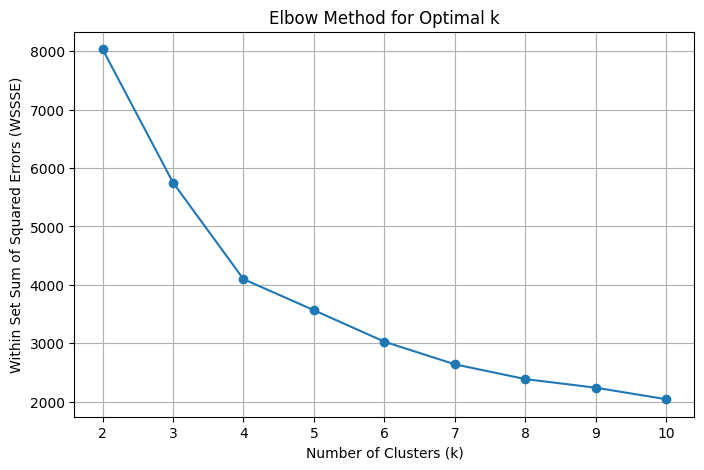

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(featuresCol='pca_features', predictionCol='clusters_pca').setK(4).setSeed(SEED)

In [ ]:
model_kmeans = kmeans.fit(data_music_genre_pca)

In [ ]:
predictions_kmeans = model_kmeans.transform(data_music_genre_pca)

In [ ]:
predictions_kmeans \
  .select('pca_features', 'clusters_pca') \
  .show(truncate=False)

+------------------------------------------+------------+
|pca_features                              |clusters_pca|
+------------------------------------------+------------+
|[-2.5070953668885663,-0.43816913737698293]|3           |
|[0.596967905663348,-4.981612052751353]    |3           |
|[4.158460276223559,0.83665250810799]      |1           |
|[2.3873448785122156,0.4877989015663361]   |0           |
|[2.650121837167907,0.575681976882043]     |0           |
|[1.4965091203367622,-1.8644183183717828]  |3           |
|[3.9235207721573224,-0.28518350023528705] |1           |
|[4.611011109831113,0.6783790472312338]    |1           |
|[2.8376900630842288,0.57129937165805]     |0           |
|[2.706690139892782,1.2593788079708255]    |0           |
|[4.698331383924286,-1.2765569680619455]   |2           |
|[3.375987496679866,-0.7560741064307498]   |2           |
|[5.608998877066019,-1.042731164439324]    |1           |
|[-0.2954946352117699,0.2763864586236268]  |3           |
|[2.5725591062

In [ ]:
pca_features_xy = predictions_kmeans.withColumn('x', vector_to_array('pca_features')[0]) \
                  .withColumn('y', vector_to_array('pca_features')[1]) \
                  .select('x', 'y', 'clusters_pca', 'genres')

In [ ]:
pca_features_xy.show()

+-------------------+--------------------+------------+--------------------+
|                  x|                   y|clusters_pca|              genres|
+-------------------+--------------------+------------+--------------------+
|-2.5070953668885663|-0.43816913737698293|           3|21st century clas...|
|  0.596967905663348|  -4.981612052751353|           3|               432hz|
|  4.158460276223559|    0.83665250810799|           1|               8-bit|
| 2.3873448785122156|  0.4877989015663361|           0|                  []|
|  2.650121837167907|   0.575681976882043|           0|          a cappella|
| 1.4965091203367622| -1.8644183183717828|           3|            abstract|
| 3.9235207721573224|-0.28518350023528705|           1|      abstract beats|
|  4.611011109831113|  0.6783790472312338|           1|    abstract hip hop|
| 2.8376900630842288|    0.57129937165805|           0|           accordeon|
|  2.706690139892782|  1.2593788079708255|           0|           accordion|

In [ ]:
fig = px.scatter(pca_features_xy.toPandas(), x = 'x', y = 'y', color = 'clusters_pca', hover_data = ['x', 'y', 'genres'])
fig.show()

Devido ao resultado não muito satisfatorio na clusterização (os clusters estão muito próximos). Seria necessário reavaliar a a quantidade de clusters (já verificada no grafico de elbow) e a quantidade de componentes principais.

Quanto os componentes do PCA estão explicando as nossas features?

In [ ]:
pca_pipeline_model.stages[2].explainedVariance


DenseVector([0.2975, 0.1212])

É possível notar que a % de explicação dos 15 componentes usando apenas 2 componentes é baixa. Precisamos reavaliar a quantidade de componentes principais que explique no mínimo 60%.

In [ ]:
# Na definição da função vamos incluir os parâmetros que gostariamos de variar, como quantidade componentes, número de clusters e colunas utilizadas
def general_pipeline(k_PCA=2, SEED=1224, k_kmeans=5, columns=X, data=data_music_genre):


  # Definição do Pipeline
  # Primeiro a vetorização das colunas selecionadas
  # Segundo a padronização dos dados com o StandardScaler
  # Terceiro o PCA com o número k_PCA de componentes
  # Quarto o KMeans com o número k_kmeans de clusters
  pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols = columns, outputCol = 'features'),\
                                StandardScaler(inputCol='features', outputCol='scaled_features'),\
                                PCA(k=k_PCA, inputCol="scaled_features", outputCol='pca_features'),\
                                KMeans(featuresCol='pca_features', predictionCol='cluster_pca', seed=SEED, k=k_kmeans)])

  # ajuste da pipeline com os dados
  model = pca_pipeline.fit(data)

  # transformação dos dados utilizando o modelo da pipeline
  predictions_kmeans = model.transform(data)

  # criando duas novas colunas a partir das primeiras duas componentes do PCA
  pca_features_xs = predictions_kmeans.withColumn("x", vector_to_array("pca_features")[0])\
                   .withColumn("y", vector_to_array("pca_features")[1])\
                   .select(['x', 'y', 'cluster_pca', 'genres'])

  # plotando as duas componentes e o cluster
  fig = px.scatter(
   pca_features_xs.toPandas(), x='x', y='y', color='cluster_pca', hover_data=['x', 'y', 'genres'])
  fig.show()

  # retornando pipeline ajustado
  return model

# Creating cluster by music

## PCA

In [ ]:
data_music.show()

+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+
|           valence|year|acousticness|       artists|      danceability|duration_ms|            energy|explicit|                  id|    instrumentalness|key|liveness|           loudness|mode|                name|popularity|speechiness|             tempo|        artists_song|
+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+
|             0.285|2000|     0.00239|      Coldplay|             0.429|     266773|0.6609999999999999|       0|3AJwUDP919kvQ9Qco...|             1.21E-4| 11|   0.234|  

In [ ]:
X = data_music.columns
X.remove('artists'),
X.remove('id'),
X.remove('name'),
X.remove('artists_song')
X

['valence',
 'year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo']

## Transforming our variables in vectors by Vector Assembler

In [ ]:
data_encoded_vector = VectorAssembler(inputCols = X, outputCol = 'features').transform(data_music)

In [ ]:
data_encoded_vector \
  .select('features') \
  .show(truncate = False, n = 5)

+-------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------+
|[0.285,2000.0,0.00239,0.429,266773.0,0.6609999999999999,0.0,1.21E-4,11.0,0.234,-7.227,1.0,84.0,0.0281,173.372]           |
|[0.613,2000.0,0.143,0.843,270507.0,0.8059999999999999,1.0,0.0,4.0,0.0771,-5.9460000000000015,0.0,80.0,0.269,94.948]      |
|[0.4,2000.0,0.00958,0.556,216880.0,0.8640000000000001,0.0,0.0,3.0,0.209,-5.87,0.0,84.0,0.0584,105.143]                   |
|[0.5429999999999999,2000.0,0.00664,0.545,233933.0,0.865,0.0,1.1E-5,11.0,0.168,-5.7079999999999975,0.0,78.0,0.0286,99.009]|
|[0.76,2000.0,0.0302,0.949,284200.0,0.6609999999999999,1.0,0.0,5.0,0.0454,-4.244,0.0,80.0,0.0572,104.504]                 |
+-------

In [ ]:
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
model_scaler = scaler.fit(data_encoded_vector)
data_music_scaler = model_scaler.transform(data_encoded_vector)

In [ ]:
data_music_scaler \
  .select('features_scaled') \
  .show(truncate = False, n = 5)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1.156596679221045,329.8170613984441,0.008403188822334736,2.5040545743834373,3.7858811737298526,2.980511298201045,0.0,6.070790766862789E-4,3.0696424994844875,1.4832857988766257,-1.

## Creating PCA model

In [ ]:
k = len(X)
k

15

In [ ]:
pca = PCA(k=k, inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(data_music_scaler)
data_music_pca = model_pca.transform(data_music_scaler)

In [ ]:
sum(model_pca.explainedVariance)*100

100.00000000000003

In [ ]:
value_list = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]
value_list

[0.21297354127107349,
 0.3459774162295507,
 0.43989805678254446,
 0.5267820578269103,
 0.6001038103117929,
 0.666571951365239,
 0.7282174213581728,
 0.7845103843321023,
 0.8350002357002614,
 0.8812446547406769,
 0.9151737562703048,
 0.9435370133056039,
 0.9699018569070161,
 0.9900947792885582,
 1.0000000000000002]

Seis componentes que explicam até 0.7 dos 15 componentes.

In [ ]:
k = sum(np.array(value_list) <= 0.7)
k

6

In [ ]:
pca = PCA(k=k, inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(data_music_scaler)
data_music_pca_final = model_pca.transform(data_music_scaler)

In [ ]:
data_music_pca_final.show()

+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+--------------------+--------------------+--------------------+
|           valence|year|acousticness|       artists|      danceability|duration_ms|            energy|explicit|                  id|    instrumentalness|key|liveness|           loudness|mode|                name|popularity|speechiness|             tempo|        artists_song|            features|     features_scaled|        pca_features|
+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+--------------------+--------------------+--

In [ ]:
data_music_pca_final \
  .select('pca_features') \
  .show(truncate = False, n=5)

+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775702,-165.3684878490617,-11.163498729833675,-139.1137428085442,14.152192300931317,-6.254422223810444]  |
|[-36.49885762774904,-167.85185045616547,-10.729023248907904,-135.90435265671286,13.38840189058717,-3.972980727830917] |
|[-35.46030091694054,-165.99633344577876,-11.361290348241944,-138.24276881246985,13.866654919305718,-4.342675920458773]|
|[-35.56301325520582,-165.59515096480598,-11.46022600703173,-137.52095740570027,15.568542803922659,-4.542073725584329] |
|[-36.54556974907565,-167.37512505802474,-11.881276527236897,-136.27798590243967,14.056847990344485,-3.583390145779214]|
+-------------------------------

In [ ]:
print(f'Percentage of variable explanation: {sum(model_pca.explainedVariance)*100:.2f}%')

Percentage of variable explanation: 66.66%


## Creating a pipeline to gathering all data

In [ ]:
pca_pipeline = Pipeline(stages = [VectorAssembler(inputCols = X, outputCol = 'features'),
                                  StandardScaler(inputCol='features', outputCol='features_scaled'),
                                  PCA(k=6, inputCol='features_scaled', outputCol='pca_features')])

In [ ]:
model_pca_pipeline = pca_pipeline.fit(data_music)

In [ ]:
project = model_pca_pipeline.transform(data_music)

In [ ]:
project \
  .select('pca_features') \
  .show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775702,-165.3684878490617,-11.163498729833675,-139.1137428085442,14.152192300931317,-6.254422223810444]  |
|[-36.49885762774904,-167.85185045616547,-10.729023248907904,-135.90435265671286,13.38840189058717,-3.972980727830917] |
|[-35.46030091694054,-165.99633344577876,-11.361290348241944,-138.24276881246985,13.866654919305718,-4.342675920458773]|
|[-35.56301325520582,-165.59515096480598,-11.46022600703173,-137.52095740570027,15.568542803922659,-4.542073725584329] |
|[-36.54556974907565,-167.37512505802474,-11.881276527236897,-136.27798590243967,14.056847990344485,-3.583390145779214]|
|[-36.7132222902623,-166.4820848

In [ ]:
project.show(5)

+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+--------------------+--------------------+--------------------+
|           valence|year|acousticness|     artists|danceability|duration_ms|            energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|               name|popularity|speechiness|  tempo|        artists_song|            features|     features_scaled|        pca_features|
+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+--------------------+--------------------+--------------------+
|             0.285|2000|     0.00239|    Coldplay| 

## K-means

In [ ]:
k_values = range(2, 20)

In [ ]:
data_music_vector = VectorAssembler(inputCols=['pca_features'], outputCol='features_pca')
transformed_data = data_music_vector.transform(data_music_pca_final)

In [ ]:
costs = []
for k in k_values:
    kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster_pca_test', k=k, seed=SEED)
    model = kmeans.fit(transformed_data)
    cost = model.summary.trainingCost
    costs.append(cost)

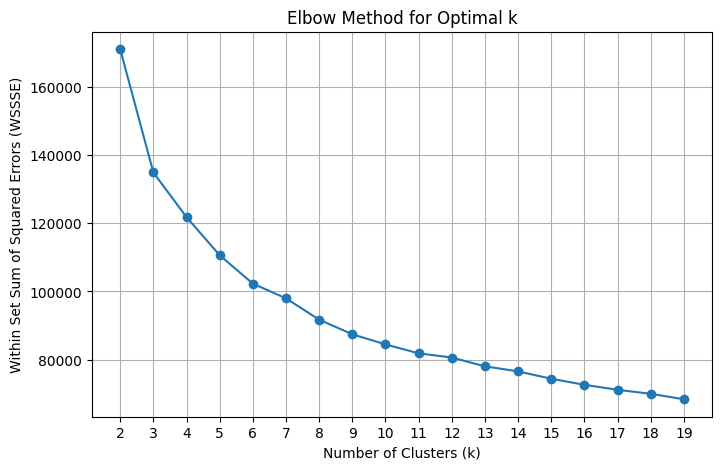

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
Kmeans = KMeans(k=10, featuresCol='pca_features', predictionCol='cluster_pca', seed=SEED)

In [ ]:
model_kmeans = Kmeans.fit(project)

In [ ]:
project_kmeans = model_kmeans.transform(project)

In [ ]:
project_kmeans \
  .select('pca_features', 'cluster_pca') \
  .show()

+--------------------+-----------+
|        pca_features|cluster_pca|
+--------------------+-----------+
|[-34.710044647757...|          6|
|[-36.498857627749...|          9|
|[-35.460300916940...|          8|
|[-35.563013255205...|          8|
|[-36.545569749075...|          8|
|[-36.713222290262...|          8|
|[-36.013246178822...|          5|
|[-36.542687712104...|          9|
|[-36.425249009784...|          8|
|[-35.872074915770...|          5|
|[-31.639065936568...|          7|
|[-35.661446890546...|          8|
|[-35.574542234850...|          5|
|[-36.022399748656...|          4|
|[-34.336941950985...|          0|
|[-35.096906055142...|          5|
|[-35.202423054032...|          6|
|[-34.942948671026...|          0|
|[-36.617404517517...|          9|
|[-34.296973387410...|          5|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
project_kmeans_xy = project_kmeans.withColumn('x', vector_to_array('pca_features')[0]) \
                  .withColumn('y', vector_to_array('pca_features')[1]) \
                  .select('x', 'y', 'cluster_pca', 'artists_song')

In [ ]:
fig = px.scatter(project_kmeans_xy.toPandas(), x = 'x', y = 'y', color = 'cluster_pca', hover_data = ['x', 'y', 'artists_song'])
fig.show()

# Recomendation app

## Music distances

In [ ]:
music_name = 'Taylor Swift - Blank Space'

In [ ]:
project_kmeans.show(5)

+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+--------------------+--------------------+--------------------+-----------+
|           valence|year|acousticness|     artists|danceability|duration_ms|            energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|               name|popularity|speechiness|  tempo|        artists_song|            features|     features_scaled|        pca_features|cluster_pca|
+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+--------------------+--------------------+--------------------+-----------+
|             0.

In [ ]:
cluster = project_kmeans.filter(project_kmeans.artists_song == music_name) \
  .select('cluster_pca') \
  .collect()[0][0] \


cluster

2

In [ ]:
suggests_music = project_kmeans.filter(project_kmeans.cluster_pca == cluster) \
  .select('artists_song', 'id', 'pca_features')

suggests_music.show()

+--------------------+--------------------+--------------------+
|        artists_song|                  id|        pca_features|
+--------------------+--------------------+--------------------+
|Train - Drops of ...|2hKdd3qO7cWr2Jo0B...|[-34.321717368827...|
| Eminem - Without Me|7lQ8MOhq6IN2w8EYc...|[-36.663794315581...|
|Maroon 5 - She Wi...|4llK75pXNWZz6KAho...|[-34.809059512962...|
|Avril Lavigne - C...|5xEM5hIgJ1jjgcEBf...|[-35.035756557524...|
|Toby Keith - Cour...|0M7mWKqwTIaVjYyxf...|[-33.783934271861...|
|Maroon 5 - She Wi...|7sapKrjDij2fpDVj0...|[-35.295324738918...|
|Red Hot Chili Pep...|1f2V8U1BiWaC9aJWm...|[-35.169747671991...|
|Red Hot Chili Pep...|1ndGB6rvxKYN9seCY...|[-35.458611626516...|
|Ricardo Arjona - ...|5UJsYyBi0CdSJl0ul...|[-34.355738031951...|
|The White Stripes...|3dPQuX8Gs42Y7b454...|[-33.782024606042...|
|     OutKast - Roses|6bUNEbXT7HovLW6Bg...|[-35.559526721657...|
|Usher - Yeah! (fe...|5rb9QrpfcKFHM1EUb...|[-36.050436933493...|
|      Usher - My Boo|68v

In [ ]:
music_components = suggests_music.filter(suggests_music.artists_song == music_name) \
  .select('pca_features') \
  .collect()[0][0]

music_components

DenseVector([-35.461, -166.9658, -12.7925, -137.9457, 13.1234, -4.1374])

We had a DenseVector() as return, which contains the six components that represent the music we like and listen to in space. We will use it as a reference for calculating suggests music distances.

In [ ]:
def distance_calculation(value):
  return euclidean(music_components, value)

udf_distance_calculation = f.udf(distance_calculation, FloatType())

suggests_music_dist = suggests_music.withColumn('Dist', udf_distance_calculation('pca_features'))

suggested_music_final = spark.createDataFrame(suggests_music_dist.sort('Dist').take(10)).select('artists_song', 'id', 'Dist')
suggested_music_final.show()

+--------------------+--------------------+-------------------+
|        artists_song|                  id|               Dist|
+--------------------+--------------------+-------------------+
|Taylor Swift - Bl...|1p80LdxRV74UKvL8g...|                0.0|
|Imagine Dragons -...|4uGY9CqDtGtaTTLg1...|0.37921473383903503|
|Katy Perry - Bon ...|4rHmKlFRiFzabiVO6...|  0.547150194644928|
|The All-American ...|6ihL9TjfRjadfEePz...| 0.6039153933525085|
|J Balvin - No Es ...|5qFeMRz4TvetPmzjr...| 0.6140614151954651|
|Dan + Shay - Take...|72HP2M4jjw4t0AIGd...| 0.6286388635635376|
|Paramore - Fake H...|6t44iU80A0h8WQ7vc...| 0.6458516716957092|
|Wallows - Drunk o...|0z9dPcBhJvqO06QMa...| 0.6634693145751953|
|Darius Rucker - B...|36ISlLb12gKuCCVTY...| 0.6824935674667358|
|Kenny Chesney - T...|40ufL61vEaDaaOitY...| 0.7050514221191406|
+--------------------+--------------------+-------------------+



In [ ]:
def recommendation(music_name):
  cluster = project_kmeans.filter(project_kmeans.artists_song == music_name).select('cluster_pca').collect()[0][0]
  suggests_music = project_kmeans.filter(project_kmeans.cluster_pca == cluster).select('artists_song', 'id', 'pca_features')
  music_components = suggests_music.filter(suggests_music.artists_song == music_name).select('pca_features').collect()[0][0]

  def distance_calculation(value):
    return euclidean(music_components, value)

  udf_distance_calculation = f.udf(distance_calculation, FloatType())

  suggests_music_dist = suggests_music.withColumn('Dist', udf_distance_calculation('pca_features'))

  suggested_music_final = spark.createDataFrame(suggests_music_dist.sort('Dist').take(10)).select('artists_song', 'id', 'Dist')

  suggested_music_final.select('artists_song').show(truncate=False)

In [ ]:
recommendation('Taylor Swift - Blank Space')

+-----------------------------------------+
|artists_song                             |
+-----------------------------------------+
|Taylor Swift - Blank Space               |
|Imagine Dragons - Machine                |
|Katy Perry - Bon appétit                 |
|The All-American Rejects - Gives You Hell|
|J Balvin - No Es Justo                   |
|Dan + Shay - Take Me Home For Christmas  |
|Paramore - Fake Happy                    |
|Wallows - Drunk on Halloween             |
|Darius Rucker - Beers And Sunshine       |
|Kenny Chesney - Tip of My Tongue         |
+-----------------------------------------+



`search_music` searches the music in the database and returns if it exists or not. This way, we'll be able to stop the music recommender process before it generates an error.

In [ ]:
def search_music(music_name, projection_m):
  resultado = projection_m.filter(projection_m.artists_song == music_name).collect()
  if len(resultado) == 0:
    return False
  return True

## Spotipy

In [ ]:
scope = "user-library-read playlist-modify-private"

OAuth = SpotifyOAuth(
        scope=scope,
        redirect_uri='http://localhost:5000/callback',
        client_id = '566b010ba65541ebb537ea12f225fee3',
        client_secret = '0d71d1191ca7418d9af15433c6acfd62')


In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id = '566b010ba65541ebb537ea12f225fee3',
                                                      client_secret = '0d71d1191ca7418d9af15433c6acfd62')

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)


In [ ]:
id = project_kmeans.filter(project_kmeans.artists_song == music_name).select('id').collect()[0][0]
id

'1p80LdxRV74UKvL8gnD7ky'

In [ ]:
track = sp.track(id)

In [ ]:
def recommendation(music_name):
  # calculation of suggested musics
  cluster = project_kmeans.filter(project_kmeans.artists_song == music_name).select('cluster_pca').collect()[0][0]
  suggests_music = project_kmeans.filter(project_kmeans.cluster_pca == cluster).select('artists_song', 'id', 'pca_features')
  music_components = suggests_music.filter(suggests_music.artists_song == music_name).select('pca_features').collect()[0][0]

  def distance_calculation(value):
    return euclidean(music_components, value)

  udf_distance_calculation = f.udf(distance_calculation, FloatType())

  suggests_music_dist = suggests_music.withColumn('Dist', udf_distance_calculation('pca_features'))

  suggested_music_final = spark.createDataFrame(suggests_music_dist.sort('Dist').take(10)).select('artists_song', 'id', 'Dist')

  suggested_music_final.select('artists_song').show(truncate=False)

  # Take the musics Id

  playlist_id = suggested_music_final.select('id').collect()

  playlist_track = []
  for id in playlist_id:
    playlist_track.append(sp.track(id[0]))

  return len(playlist_track)

In [ ]:
recommendation('Taylor Swift - Blank Space')

+-----------------------------------------+
|artists_song                             |
+-----------------------------------------+
|Taylor Swift - Blank Space               |
|Imagine Dragons - Machine                |
|Katy Perry - Bon appétit                 |
|The All-American Rejects - Gives You Hell|
|J Balvin - No Es Justo                   |
|Dan + Shay - Take Me Home For Christmas  |
|Paramore - Fake Happy                    |
|Wallows - Drunk on Halloween             |
|Darius Rucker - Beers And Sunshine       |
|Kenny Chesney - Tip of My Tongue         |
+-----------------------------------------+



10

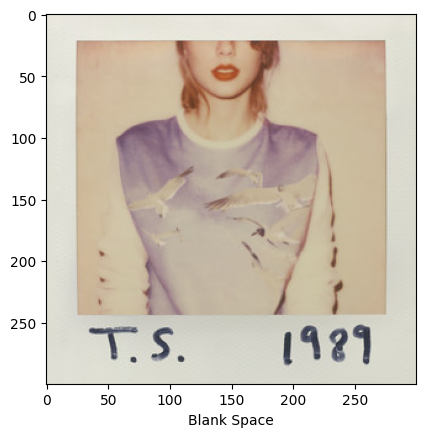

In [ ]:
music_name = 'Taylor Swift - Blank Space'

id = project_kmeans\
          .filter(project_kmeans.artists_song == music_name)\
          .select('id').collect()[0][0]

track = sp.track(id)

url = track["album"]["images"][1]["url"]
name = track["name"]

image = io.imread(url)
plt.imshow(image)
plt.xlabel(name, fontsize = 10)
plt.show()


In [ ]:
def visualize_songs(name,url):

    plt.figure(figsize=(15,10))
    columns = 5
    for i, u in enumerate(url):
        ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
        image = io.imread(u)
        plt.imshow(image)
        ax.get_yaxis().set_visible(False)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(name[i], fontsize = 10)
        plt.tight_layout(h_pad=0.7, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.grid(visible=None)
        #plt.axis('off')
    plt.show()



In [ ]:
playlist_id = suggested_music_final.select('id').collect()

name = []
url = []
for i in playlist_id:
    track = sp.track(i[0])
    url.append(track["album"]["images"][1]["url"])
    name.append(track["name"])


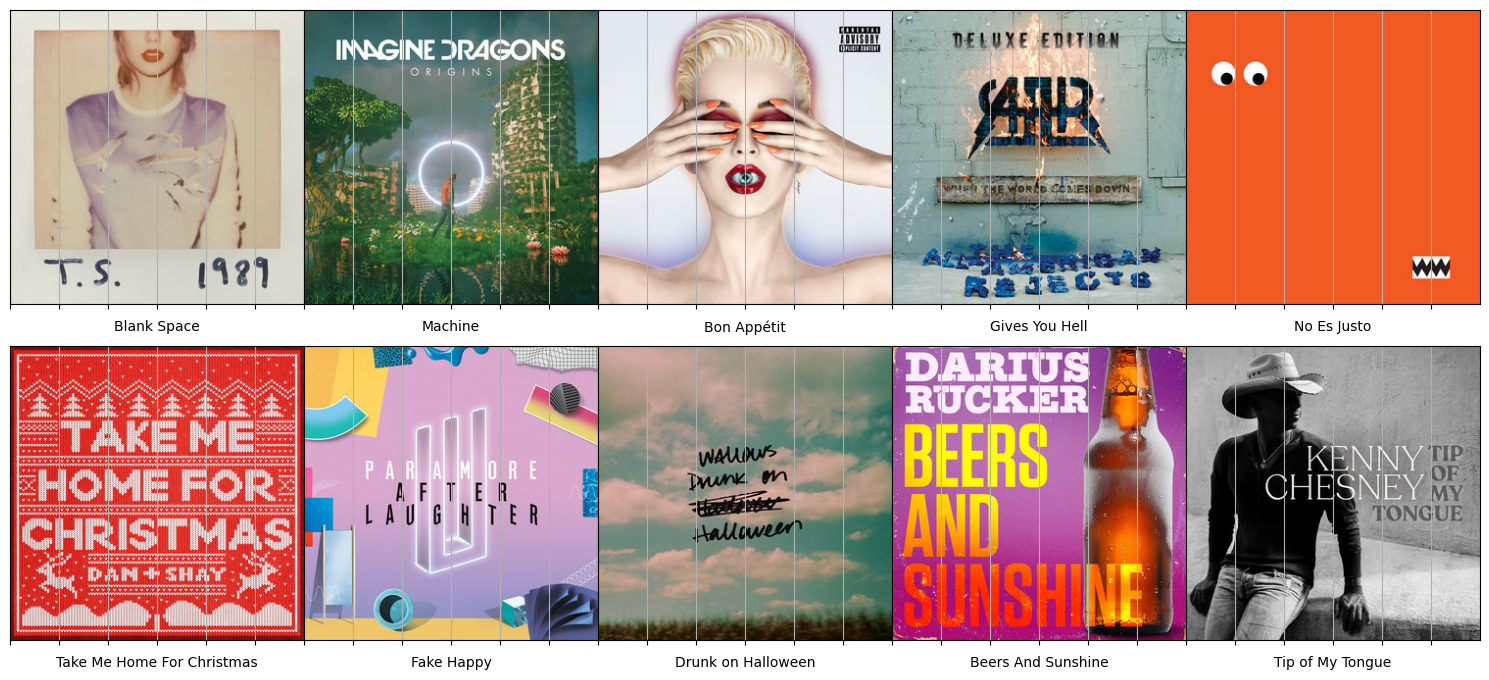

In [ ]:
visualize_songs(name, url)

In [ ]:
def recommendation(music_name):
  # calculation of suggested musics
  cluster = project_kmeans.filter(project_kmeans.artists_song == music_name).select('cluster_pca').collect()[0][0]
  suggests_music = project_kmeans.filter(project_kmeans.cluster_pca == cluster).select('artists_song', 'id', 'pca_features')
  music_components = suggests_music.filter(suggests_music.artists_song == music_name).select('pca_features').collect()[0][0]

  def distance_calculation(value):
    return euclidean(music_components, value)

  udf_distance_calculation = f.udf(distance_calculation, FloatType())

  suggests_music_dist = suggests_music.withColumn('Dist', udf_distance_calculation('pca_features'))

  suggested_music_final = spark.createDataFrame(suggests_music_dist.sort('Dist').take(10)).select('artists_song', 'id', 'Dist')

  # Take the musics Id

  playlist_id = suggested_music_final.select('id').collect()

  name = []
  url = []
  for i in playlist_id:
      track = sp.track(i[0])
      url.append(track["album"]["images"][1]["url"])
      name.append(track["name"])

  # Ploting the images

  plt.figure(figsize=(15,10))
  columns = 5
  for i, u in enumerate(url):
          ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
          image = io.imread(u)
          plt.imshow(image)
          ax.get_yaxis().set_visible(False)
          plt.xticks(color = 'w', fontsize = 0.1)
          plt.yticks(color = 'w', fontsize = 0.1)
          plt.xlabel(name[i], fontsize = 10)
          plt.tight_layout(h_pad=0.7, w_pad=0)
          plt.subplots_adjust(wspace=None, hspace=None)
          plt.grid(visible=None)
          #plt.axis('off')
  plt.show()

In [100]:
data_music.show()

+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+
|           valence|year|acousticness|       artists|      danceability|duration_ms|            energy|explicit|                  id|    instrumentalness|key|liveness|           loudness|mode|                name|popularity|speechiness|             tempo|        artists_song|
+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+
|             0.285|2000|     0.00239|      Coldplay|             0.429|     266773|0.6609999999999999|       0|3AJwUDP919kvQ9Qco...|             1.21E-4| 11|   0.234|  

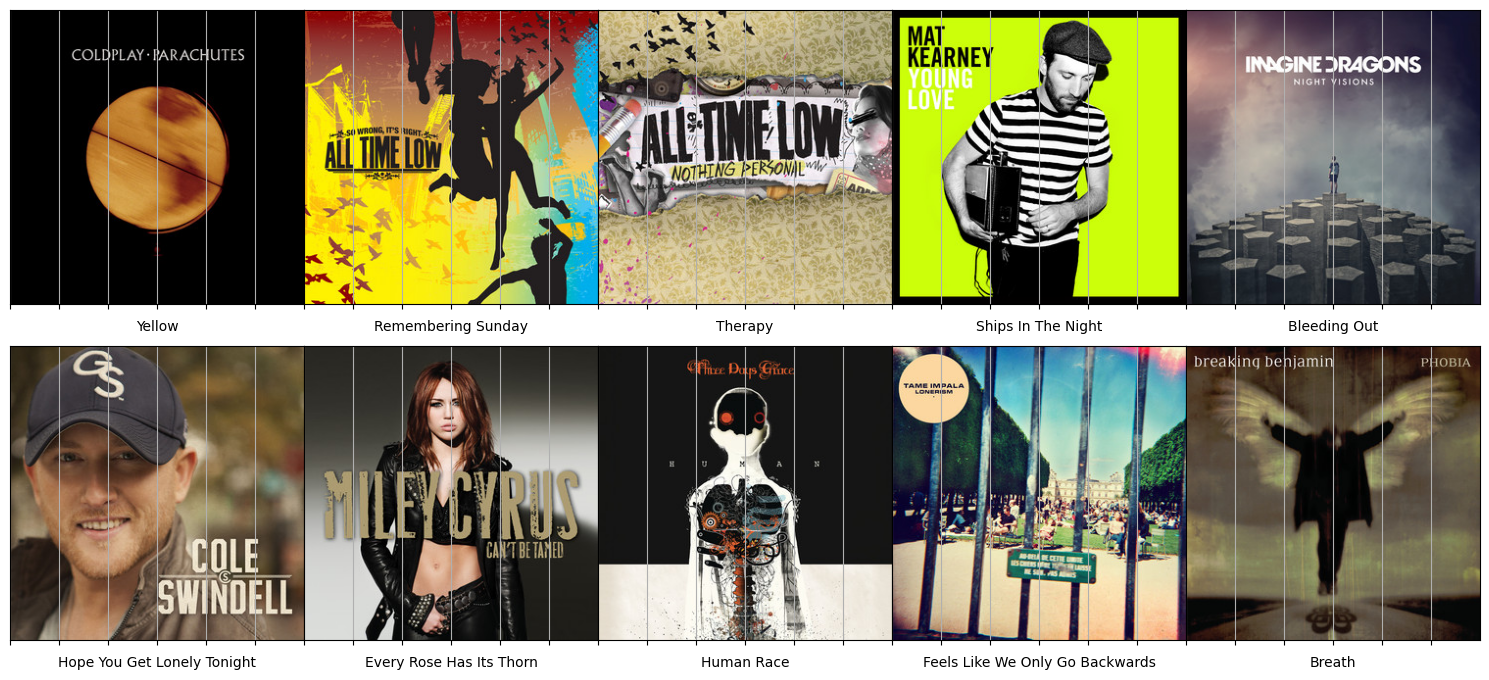

In [102]:
recommendation('Coldplay - Yellow')